# Квадратичная функция <!--Quadratic function -->
Обновлено 04.11.2020

$$f(x) = \frac{1}{2}(x, Q x) + (b, x)$$
$$\nabla f(x) = Qx + b$$

$$x^* = - Q^{-1} b$$

In [ ]:
import math
from typing import Callable, List, Dict

import numpy as np

array = np.ndarray

In [1]:
# utils


def check_precision(precision: float, x_array: list, f: Callable) -> bool:
    return len(x_array) == 1 or abs(f(x_array[-1]) - f(x_array[-2])) > precision


def quad(q: array, b: array, x: array) -> array:
    return (0.5 * q.dot(x) + b).dot(x)


def quad_grad(q: array, b: array, x: array) -> array:
    return q.dot(x) + b


def quad_2d_xy(q: array, b: array, x: array, y: array) -> array:
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i, j] = quad(q, b, np.array([x[i, j], y[i, j]]))
    return z


def calc_gamma(q: array, b: array, fg: array, x: array, gamma: float) -> array:
    return quad(q, b, x + gamma * fg)


def gss(q: array, b: array, x: array, g_a: float, g_b: float, epsilon: float, f_grad: Callable) -> float:
    phi = 1 + (math.sqrt(5) - 1) / 2
    fg = -f_grad(x)

    while abs(g_a - g_b) >= epsilon:
        _a = g_b - (g_b - g_a) / phi
        _b = g_a + (g_b - g_a) / phi
        f1 = calc_gamma(q, b, fg, x, _a)
        f2 = calc_gamma(q, b, fg, x, _b)
        if f1 > f2:
            g_a = _a
        else:
            g_b = _b

    return (g_a + g_b) / 2


def armijo(x: array, alpha: float, theta: float, epsilon: float, f: Callable, f_grad: Callable) -> float:
    fg = f_grad(x)
    fx = f(x)
    _alpha = alpha
    while f(x - _alpha * fg) > fx - epsilon * _alpha * (np.dot(fg, fg)):
        _alpha *= theta
    return _alpha


def relaxation(q: array, b: array, x: array, f_grad: Callable) -> array:
    vec = -f_grad(x)
    return -(q.dot(x).dot(vec) + q.dot(vec).dot(x) + 2 * b.dot(vec)) / (2 * q.dot(vec).dot(vec))


def fib_list(n: int) -> array:
    fibonacci_numbers = [0, 1]
    for i in range(2, n):
        fibonacci_numbers.append(fibonacci_numbers[i - 1] + fibonacci_numbers[i - 2])
    return np.array(fibonacci_numbers)


def fibonacci(q: array, b: array, x: array, g_a: float, g_b: float, fib: array, fg: array) -> float:
    n = 10
    g1 = g_a + (g_b - g_a) * fib[n - 2] / fib[n]
    g2 = g_a + (g_b - g_a) * fib[n - 1] / fib[n]
    f1, f2 = calc_gamma(q, b, fg, x, g1), calc_gamma(q, b, fg, x, g2)

    while n > 1:
        n -= 1
        if f1 > f2:
            g_a = g1
            g1 = g2
            g2 = g_b - (g1 - g_a)
            f1, f2 = f2, calc_gamma(q, b, fg, x, g2)
        else:
            g_b = g2
            g2 = g1
            g1 = g_a + (g_b - g2)
            f2 = f1
            f1 = calc_gamma(q, b, fg, x, g1)

    return (g1 + g2) / 2


def werewolf(state: List[bool] = [True]) -> array:  # noqa
    state[0] = not state[0]
    return np.array([1, 0]) if state[0] else np.array([0, 1])


def changeable(x: array, q: array, b: array, state: List[bool]):
    vec = werewolf(state)
    return -(q.dot(x).dot(vec) + q.dot(vec).dot(x) + 2 * b.dot(vec)) / (2 * q.dot(vec).dot(vec))

In [2]:
# solvers


def solver(
        x0: array,
        f: Callable,
        f_grad: Callable,
        gamma: Callable,
        iterations=70,
        precision=1e-6
) -> Dict[str, list]:
    """ Общая модель солверов на спуске """
    x = x0.copy()
    x_array, f_array = [x], [f(x)]
    k = 0

    while k < iterations and check_precision(precision, x_array, f):
        x = x + gamma(x) * (-f_grad(x))
        x_array.append(x)
        f_array.append(f(x))
        k += 1

    print(f'{k} iterations is taken, f(x^k) = {f_array[-1]}')
    return {'x_k': x_array, 'f_k': f_array}


def const_step_solver(x0: array, f: Callable, f_grad: Callable, iterations=70, precision=1e-6) -> Dict[str, list]:
    return solver(x0, f, f_grad, lambda x: 0.55, iterations, precision)


def armijo_solver(x0: array, f: Callable, f_grad: Callable, iterations=70, precision=1e-6):
    return solver(x0, f, f_grad, lambda x: armijo(x, 1., .5, .1, f, f_grad), iterations, precision)


def gss_solver(x0: array, f: Callable, f_grad: Callable, q: array, b: array, iterations=70, precision=1e-6):
    return solver(x0, f, f_grad, lambda x: gss(q, b, x, 0, 10., 1e-6, f_grad), iterations, precision)


def relaxation_solver(x0: array, f: Callable, f_grad: Callable, q: array, b: array, iterations=70, precision=1e-6):
    return solver(x0, f, f_grad, lambda x: relaxation(q, b, x, f_grad), iterations, precision)


def werewolf_solver(x0: array, f: Callable, q: array, b: array, iterations=70, precision=1e-6):
    fst, snd = [True], [True]
    return solver(x0, f, lambda x: -werewolf(fst), lambda x: changeable(x, q, b, snd), iterations, precision)


def fibonacci_solver(x0: array, f: Callable, q: array, b: array, iterations=70, precision=1e-6):
    fst, snd = [True], [True]
    fl = fib_list(15)
    gm = lambda x: fibonacci(q, b, x, -10., 10., fl, werewolf(snd))  # noqa
    return solver(x0, f, lambda x: -werewolf(fst), gm, iterations, precision)

In [3]:
import matplotlib.pyplot as plt


def draw_gradients(q, b, x_0, x_star, first, second):
    # prepare image
    _, axes = plt.subplots(1, 2, figsize=(15, 5))
    # plot contours
    X, Y = np.meshgrid(np.linspace(-5, 15, 400), np.linspace(-10, 3, 100))  # noqa
    Z_quad = quad_2d_xy(q, b, X, Y)  # noqa

    # some step-size
    gamma = 0.6
    # levels for contour lines
    levels = quad(q, b, x_star) + np.linspace(0, 10, 6) ** 2

    # on both sub-plots plot:
    for k in (0, 1):
        # having equal axes is important to see if lines orthogonal or not
        axes[k].axis('equal')
        # minimum
        axes[k].plot(x_star[0], x_star[1], '*')
        # initial point
        axes[k].plot(x_0[0], x_0[1], 'or')
        # a segment in anti-gradient direction
        axes[k].plot((x_0[0], (x_0 - gamma * quad_grad(q, b, x_0))[0]),
                     (x_0[1], (x_0 - gamma * quad_grad(q, b, x_0))[1]), 'r')
        # plot contour lines
        axes[k].contour(X, Y, Z_quad, levels)

    x_data = []
    for j, data in enumerate([first, second]):
        # convert list of vectors to 2D-array of dimension N x 2
        _x_data = np.array(data['x_k'])
        # plot on second image
        axes[j].plot(_x_data[:, 0], _x_data[:, 1])
        x_data.append(_x_data)

    print(f'Function value in optimal point (minimum), f* = {quad(q, b, x_star)}')
    # plt.show() - not needed if %matplotlib magic is used

    # additional build extra plots for convergence rates
    _, axes = plt.subplots(4, 2, figsize=(15, 10))
    plt.tight_layout()
    # grids on all subplots
    for j in range(2):
        for k in range(4):
            axes[k][j].grid()

    for j, data in enumerate([first, second]):
        # residual f(x_k) - f* (with broadcasting)
        f_k_residual = data['f_k'] - quad(q, b, x_star)
        N = len(f_k_residual)  # noqa

        # calculate residuals for vectors x_k - x* by two ways:
        # 1 - by dubbing x* and subtracting arrays of the same size
        x_k_residual = x_data[j] - np.kron(np.ones((N, 1)), x_star)
        # 2 - by broadcasting
        x_k_residual_copy = x_data[j] - np.atleast_2d(x_star)
        # check identity of the arrays
        np.testing.assert_array_equal(x_k_residual_copy, x_k_residual)

        axes[0][j].set_title('Function residual')
        axes[0][j].plot(f_k_residual, )
        axes[1][j].set_title('Logarithmic function residual')
        axes[1][j].plot(np.log(f_k_residual), )
        axes[2][j].set_title('Value residual (Euclidean norm)')
        axes[2][j].plot(np.arange(N), np.linalg.norm(x_k_residual, axis=1))
        axes[3][j].set_title('Logarithmic value residual (Euclidean norm)')
        axes[3][j].plot(np.arange(N), np.log(np.linalg.norm(x_k_residual, axis=1)))

    plt.show()

In [4]:
np.random.seed(42)

# generate matrix Q and vector b
n = 5
m = 2
A = np.random.rand(n, m)
b = 4 * np.random.rand(m)
Q = A.T @ A

# important parameters of the problem
eigs = np.linalg.eigvals(Q)
L = max(eigs)
mu = min(eigs)

print(f'b = {b}')
print(f'Q = \n{Q}')
print(f'mu = {mu}, L = {L}')

# minimum
x_star = -np.linalg.inv(Q) @ b
# some initial point
x_0 = x_star - [8, -1.5]

b = [0.08233798 3.87963941]
Q = 
[[1.06515021 1.29457678]
 [1.29457678 2.53821185]]
mu = 0.31224936468495423, L = 3.291112700725653


42 iterations is taken, f(x^k) = -7.406398183570684
39 iterations is taken, f(x^k) = -7.406397815124172
Function value in optimal point (minimum), f* = -7.406399665468872


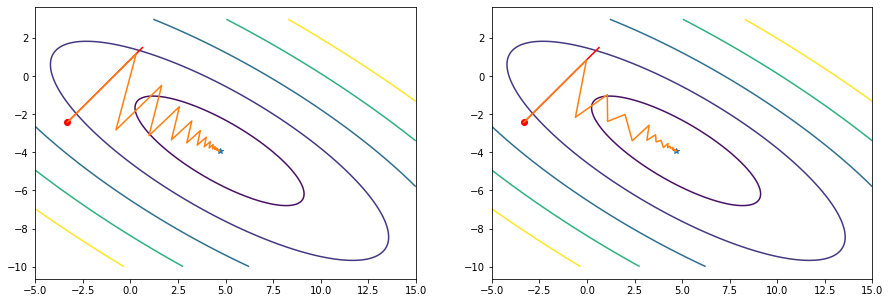

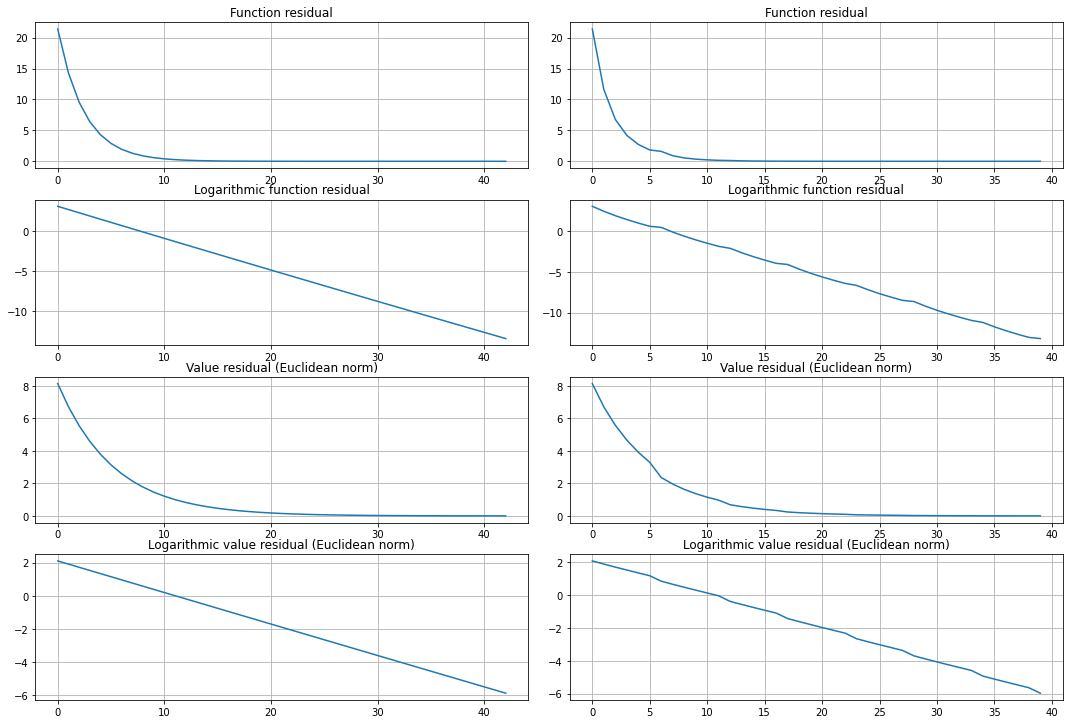

In [5]:
first = const_step_solver(x_0, lambda x: quad(Q, b, x), lambda x: quad_grad(Q, b, x))
second = armijo_solver(x_0, lambda x: quad(Q, b, x), lambda x: quad_grad(Q, b, x))

draw_gradients(Q, b, x_0, x_star, first, second)

17 iterations is taken, f(x^k) = -7.406399301419553
17 iterations is taken, f(x^k) = -7.406399301352675
Function value in optimal point (minimum), f* = -7.406399665468872


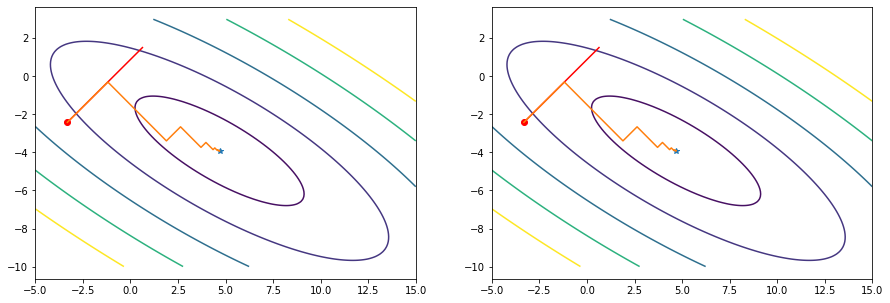

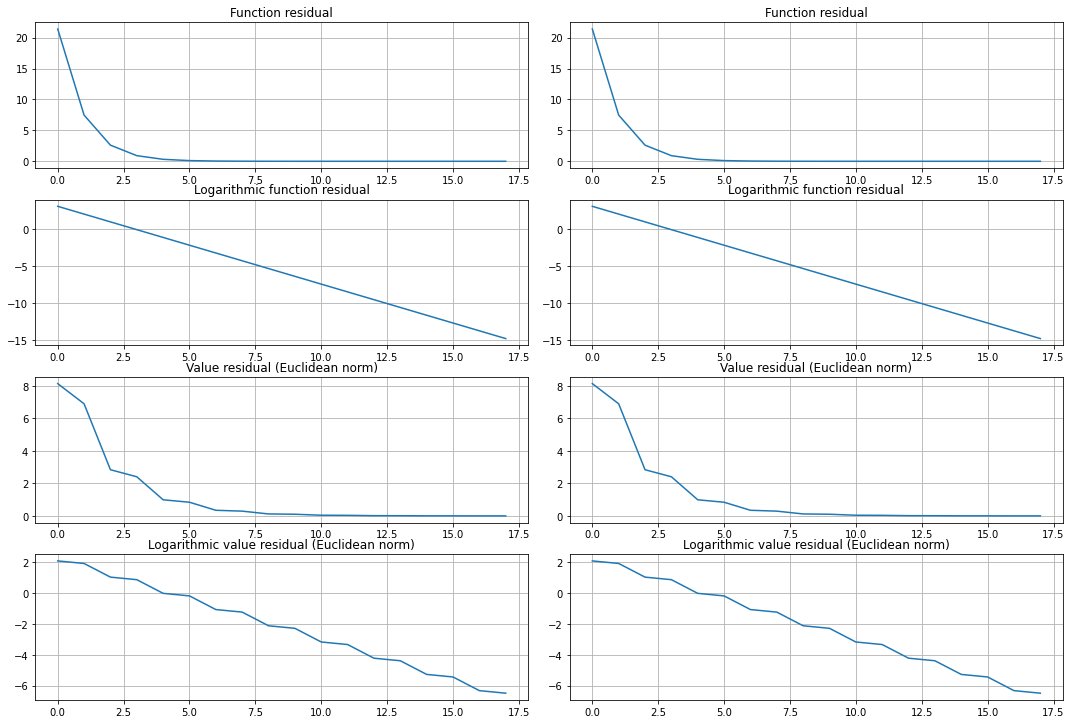

In [6]:
first = gss_solver(x_0, lambda x: quad(Q, b, x), lambda x: quad_grad(Q, b, x), Q, b)
second = relaxation_solver(x_0, lambda x: quad(Q, b, x), lambda x: quad_grad(Q, b, x), Q, b)

draw_gradients(Q, b, x_0, x_star, first, second)

13 iterations is taken, f(x^k) = -7.403777545784541
35 iterations is taken, f(x^k) = -7.406398540239484
Function value in optimal point (minimum), f* = -7.406399665468872


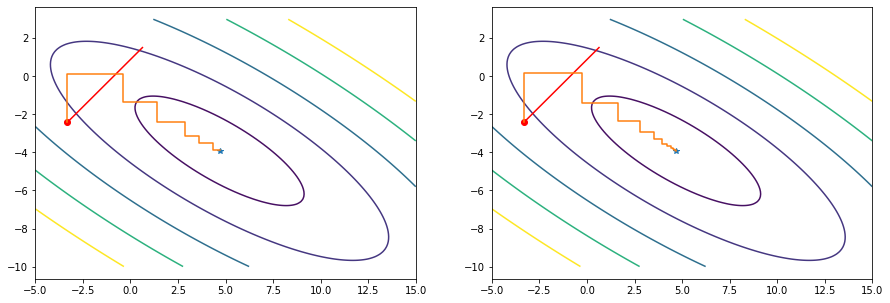

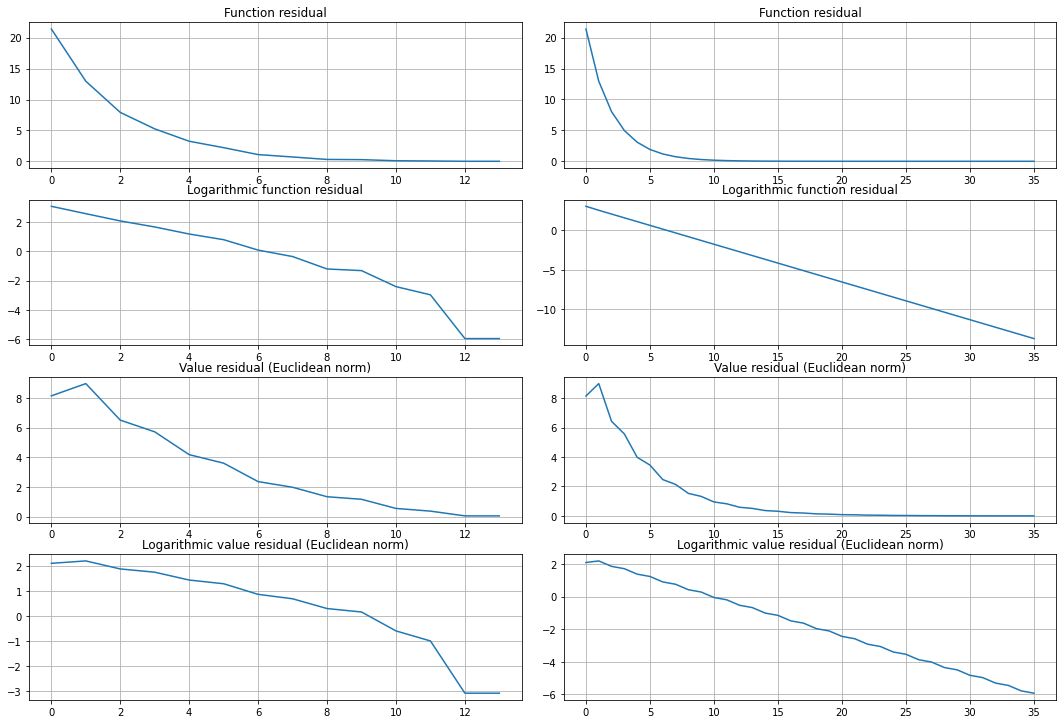

In [7]:
first = fibonacci_solver(x_0, lambda x: quad(Q, b, x), Q, b)
second = werewolf_solver(x_0, lambda x: quad(Q, b, x), Q, b)

draw_gradients(Q, b, x_0, x_star, first, second)